In [1]:
import tensorflow as tf

In [2]:
print(tf.__version__)

1.2.1


In [4]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/data')

Extracting /data\train-images-idx3-ubyte.gz
Extracting /data\train-labels-idx1-ubyte.gz
Extracting /data\t10k-images-idx3-ubyte.gz
Extracting /data\t10k-labels-idx1-ubyte.gz


1


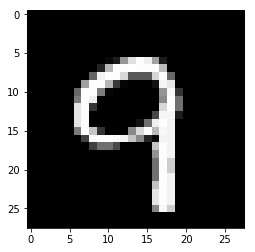

In [37]:
img = mnist.train.images[0: 10]
for i in range(10):
    plt.imshow(img[i].reshape(28, 28), cmap='Greys_r')
print(mnist.train.labels[1])

In [7]:
def get_inputs(real_size, noise_size):
    input_real = tf.placeholder(tf.float32, [None, real_size], name='real_img')
    input_noise = tf.placeholder(tf.float32, [None, noise_size], name='noise_img')
    return input_real, input_noise

In [8]:
def get_generator(noise_img, n_units, out_dim, reuse=False, alpha=0.01):
    """
    生成器
    
    noise_img: 生成器的输入
    n_units: 隐层单元个数
    out_dim: 生成器输出tensor的size，这里应该为32*32=784
    alpha: leaky ReLU系数
    """
    with tf.variable_scope("generator", reuse=reuse):
        # hidden layer
        hidden1 = tf.layers.dense(noise_img, n_units)
        # leaky ReLU
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        # dropout
        hidden1 = tf.layers.dropout(hidden1, rate=0.2)

        # logits & outputs
        logits = tf.layers.dense(hidden1, out_dim)
        outputs = tf.tanh(logits)
        
        return logits, outputs

In [9]:
def get_discriminator(img, n_units, reuse=False, alpha=0.01):
    """
    判别器
    
    n_units: 隐层结点数量
    alpha: Leaky ReLU系数
    """
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # hidden layer
        hidden1 = tf.layers.dense(img, n_units)
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        
        # logits & outputs
        logits = tf.layers.dense(hidden1, 1)
        outputs = tf.sigmoid(logits)
        
        return logits, outputs

In [10]:
# 定义参数
# 真实图像的size
img_size = mnist.train.images[0].shape[0]
# 传入给generator的噪声size
noise_size = 100
# 生成器隐层参数
g_units = 128
# 判别器隐层参数
d_units = 128
# leaky ReLU的参数
alpha = 0.01
# learning_rate
learning_rate = 0.001
# label smoothing
smooth = 0.1

In [11]:
tf.reset_default_graph()

real_img, noise_img = get_inputs(img_size, noise_size)

# generator
g_logits, g_outputs = get_generator(noise_img, g_units, img_size)

# discriminator
d_logits_real, d_outputs_real = get_discriminator(real_img, d_units)
d_logits_fake, d_outputs_fake = get_discriminator(g_outputs, d_units, reuse=True)

In [12]:
# discriminator的loss
# 识别真实图片
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                     labels=tf.ones_like(d_logits_real)) * (1 - smooth))
# 识别生成的图片
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                     labels=tf.zeros_like(d_logits_fake)))
# 总体loss
d_loss = tf.add(d_loss_real, d_loss_fake)

# generator的loss
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                labels=tf.ones_like(d_logits_fake)) * (1 - smooth))

In [13]:
train_vars = tf.trainable_variables()

# generator中的tensor
g_vars = [var for var in train_vars if var.name.startswith("generator")]
# discriminator中的tensor
d_vars = [var for var in train_vars if var.name.startswith("discriminator")]

# optimizer
d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

In [26]:
# batch_size
batch_size = 64
# 训练迭代轮数
epochs = 500
# 抽取样本数
n_sample = 25

# 存储测试样例
samples = []
# 存储loss
losses = []
# 保存生成器变量
saver = tf.train.Saver(var_list = g_vars)
# 开始训练
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for batch_i in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            batch_images = batch[0].reshape((batch_size, 784))
            # 对图像像素进行scale，这是因为tanh输出的结果介于(-1,1),real和fake图片共享discriminator的参数
            batch_images = batch_images*2 - 1
            
            # generator的输入噪声
            batch_noise = np.random.uniform(-1, 1, size=(batch_size, noise_size))
            
            # Run optimizers
            sess.run(d_train_opt, feed_dict={real_img: batch_images, noise_img: batch_noise})
            sess.run(g_train_opt, feed_dict={noise_img: batch_noise})
        
        # 每一轮结束计算loss
        train_loss_d = sess.run(d_loss, 
                                feed_dict = {real_img: batch_images, 
                                             noise_img: batch_noise})
        # real img loss
        train_loss_d_real = sess.run(d_loss_real, 
                                     feed_dict = {real_img: batch_images, 
                                                 noise_img: batch_noise})
        # fake img loss
        train_loss_d_fake = sess.run(d_loss_fake, 
                                    feed_dict = {real_img: batch_images, 
                                                 noise_img: batch_noise})
        # generator loss
        train_loss_g = sess.run(g_loss, 
                                feed_dict = {noise_img: batch_noise})
        
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}(Real: {:.4f} + Fake: {:.4f})...".format(train_loss_d, train_loss_d_real, train_loss_d_fake),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # 记录各类loss值
        losses.append((train_loss_d, train_loss_d_real, train_loss_d_fake, train_loss_g))
        
        # 抽取样本后期进行观察
        sample_noise = np.random.uniform(-1, 1, size=(n_sample, noise_size))
        gen_samples = sess.run(get_generator(noise_img, g_units, img_size, reuse=True),
                               feed_dict={noise_img: sample_noise})
        samples.append(gen_samples)
        
        # 存储checkpoints
        saver.save(sess, './checkpoints/generator.ckpt')

# 将sample的生成数据记录下来
with open('train_samples.pkl', 'wb') as f:
    pickle.dump(samples, f)

Epoch 1/500... Discriminator Loss: 0.0120(Real: 0.0012 + Fake: 0.0108)... Generator Loss: 4.8771
Epoch 2/500... Discriminator Loss: 0.1989(Real: 0.0666 + Fake: 0.1323)... Generator Loss: 5.1623
Epoch 3/500... Discriminator Loss: 0.6616(Real: 0.2629 + Fake: 0.3987)... Generator Loss: 2.0994
Epoch 4/500... Discriminator Loss: 3.4995(Real: 0.5797 + Fake: 2.9198)... Generator Loss: 2.0564
Epoch 5/500... Discriminator Loss: 0.6253(Real: 0.4710 + Fake: 0.1543)... Generator Loss: 3.3238
Epoch 6/500... Discriminator Loss: 0.8196(Real: 0.2294 + Fake: 0.5902)... Generator Loss: 3.0399
Epoch 7/500... Discriminator Loss: 1.1926(Real: 0.4785 + Fake: 0.7141)... Generator Loss: 1.6028
Epoch 8/500... Discriminator Loss: 1.3670(Real: 0.3350 + Fake: 1.0320)... Generator Loss: 2.0563
Epoch 9/500... Discriminator Loss: 1.2973(Real: 0.6315 + Fake: 0.6657)... Generator Loss: 1.7046
Epoch 10/500... Discriminator Loss: 0.6484(Real: 0.3539 + Fake: 0.2945)... Generator Loss: 1.9489
Epoch 11/500... Discriminator

Epoch 85/500... Discriminator Loss: 0.8788(Real: 0.5345 + Fake: 0.3443)... Generator Loss: 1.5980
Epoch 86/500... Discriminator Loss: 0.6752(Real: 0.2903 + Fake: 0.3849)... Generator Loss: 1.4860
Epoch 87/500... Discriminator Loss: 0.8554(Real: 0.5288 + Fake: 0.3266)... Generator Loss: 1.6250
Epoch 88/500... Discriminator Loss: 0.8818(Real: 0.3640 + Fake: 0.5179)... Generator Loss: 1.1874
Epoch 89/500... Discriminator Loss: 0.9414(Real: 0.4121 + Fake: 0.5292)... Generator Loss: 1.1880
Epoch 90/500... Discriminator Loss: 0.9663(Real: 0.4959 + Fake: 0.4704)... Generator Loss: 1.4118
Epoch 91/500... Discriminator Loss: 1.0182(Real: 0.7155 + Fake: 0.3028)... Generator Loss: 1.7606
Epoch 92/500... Discriminator Loss: 1.1243(Real: 0.5266 + Fake: 0.5977)... Generator Loss: 1.1576
Epoch 93/500... Discriminator Loss: 1.0636(Real: 0.5593 + Fake: 0.5043)... Generator Loss: 1.3585
Epoch 94/500... Discriminator Loss: 0.9327(Real: 0.3049 + Fake: 0.6278)... Generator Loss: 1.2110
Epoch 95/500... Disc

Epoch 168/500... Discriminator Loss: 0.8726(Real: 0.3935 + Fake: 0.4791)... Generator Loss: 1.3221
Epoch 169/500... Discriminator Loss: 0.8129(Real: 0.3188 + Fake: 0.4941)... Generator Loss: 1.4091
Epoch 170/500... Discriminator Loss: 0.9780(Real: 0.4794 + Fake: 0.4986)... Generator Loss: 1.3020
Epoch 171/500... Discriminator Loss: 0.7817(Real: 0.4110 + Fake: 0.3707)... Generator Loss: 1.5022
Epoch 172/500... Discriminator Loss: 0.7461(Real: 0.3166 + Fake: 0.4295)... Generator Loss: 1.4901
Epoch 173/500... Discriminator Loss: 0.8237(Real: 0.4370 + Fake: 0.3867)... Generator Loss: 1.6082
Epoch 174/500... Discriminator Loss: 0.8039(Real: 0.3422 + Fake: 0.4617)... Generator Loss: 1.3467
Epoch 175/500... Discriminator Loss: 0.8010(Real: 0.3888 + Fake: 0.4123)... Generator Loss: 1.5690
Epoch 176/500... Discriminator Loss: 0.8491(Real: 0.2950 + Fake: 0.5540)... Generator Loss: 1.2217
Epoch 177/500... Discriminator Loss: 0.8874(Real: 0.5077 + Fake: 0.3796)... Generator Loss: 1.6934
Epoch 178/

Epoch 251/500... Discriminator Loss: 0.8511(Real: 0.4530 + Fake: 0.3981)... Generator Loss: 1.4998
Epoch 252/500... Discriminator Loss: 0.9282(Real: 0.3924 + Fake: 0.5358)... Generator Loss: 1.2590
Epoch 253/500... Discriminator Loss: 0.9235(Real: 0.4035 + Fake: 0.5200)... Generator Loss: 1.5386
Epoch 254/500... Discriminator Loss: 0.9733(Real: 0.4784 + Fake: 0.4950)... Generator Loss: 1.4079
Epoch 255/500... Discriminator Loss: 0.8433(Real: 0.3266 + Fake: 0.5167)... Generator Loss: 1.3825
Epoch 256/500... Discriminator Loss: 0.7179(Real: 0.3611 + Fake: 0.3567)... Generator Loss: 1.6582
Epoch 257/500... Discriminator Loss: 0.8422(Real: 0.3476 + Fake: 0.4946)... Generator Loss: 1.2660
Epoch 258/500... Discriminator Loss: 0.7944(Real: 0.3635 + Fake: 0.4310)... Generator Loss: 1.6035
Epoch 259/500... Discriminator Loss: 0.8902(Real: 0.4044 + Fake: 0.4859)... Generator Loss: 1.5384
Epoch 260/500... Discriminator Loss: 0.7719(Real: 0.3716 + Fake: 0.4003)... Generator Loss: 1.4252
Epoch 261/

Epoch 334/500... Discriminator Loss: 0.8994(Real: 0.4938 + Fake: 0.4057)... Generator Loss: 1.5364
Epoch 335/500... Discriminator Loss: 0.7664(Real: 0.3835 + Fake: 0.3830)... Generator Loss: 1.7901
Epoch 336/500... Discriminator Loss: 0.9059(Real: 0.4647 + Fake: 0.4411)... Generator Loss: 1.5198
Epoch 337/500... Discriminator Loss: 0.7810(Real: 0.3175 + Fake: 0.4635)... Generator Loss: 1.4591
Epoch 338/500... Discriminator Loss: 0.8177(Real: 0.4179 + Fake: 0.3998)... Generator Loss: 1.7588
Epoch 339/500... Discriminator Loss: 0.7791(Real: 0.4977 + Fake: 0.2814)... Generator Loss: 1.8578
Epoch 340/500... Discriminator Loss: 0.7329(Real: 0.2853 + Fake: 0.4476)... Generator Loss: 1.7393
Epoch 341/500... Discriminator Loss: 0.9352(Real: 0.4343 + Fake: 0.5009)... Generator Loss: 1.3616
Epoch 342/500... Discriminator Loss: 0.7489(Real: 0.2875 + Fake: 0.4614)... Generator Loss: 1.4412
Epoch 343/500... Discriminator Loss: 1.0009(Real: 0.4879 + Fake: 0.5129)... Generator Loss: 1.5500
Epoch 344/

Epoch 417/500... Discriminator Loss: 0.8763(Real: 0.6110 + Fake: 0.2653)... Generator Loss: 1.9283
Epoch 418/500... Discriminator Loss: 0.8743(Real: 0.4578 + Fake: 0.4165)... Generator Loss: 1.9038
Epoch 419/500... Discriminator Loss: 0.7208(Real: 0.4265 + Fake: 0.2943)... Generator Loss: 1.7645
Epoch 420/500... Discriminator Loss: 0.9132(Real: 0.3790 + Fake: 0.5343)... Generator Loss: 1.3348
Epoch 421/500... Discriminator Loss: 0.9664(Real: 0.4542 + Fake: 0.5122)... Generator Loss: 1.3102
Epoch 422/500... Discriminator Loss: 0.8672(Real: 0.3327 + Fake: 0.5345)... Generator Loss: 1.5229
Epoch 423/500... Discriminator Loss: 0.7895(Real: 0.4344 + Fake: 0.3551)... Generator Loss: 1.7363
Epoch 424/500... Discriminator Loss: 0.7507(Real: 0.4386 + Fake: 0.3121)... Generator Loss: 1.7454
Epoch 425/500... Discriminator Loss: 0.8037(Real: 0.2442 + Fake: 0.5595)... Generator Loss: 1.2185
Epoch 426/500... Discriminator Loss: 0.7579(Real: 0.3756 + Fake: 0.3823)... Generator Loss: 1.5970
Epoch 427/

Epoch 500/500... Discriminator Loss: 0.8735(Real: 0.4801 + Fake: 0.3934)... Generator Loss: 1.6305


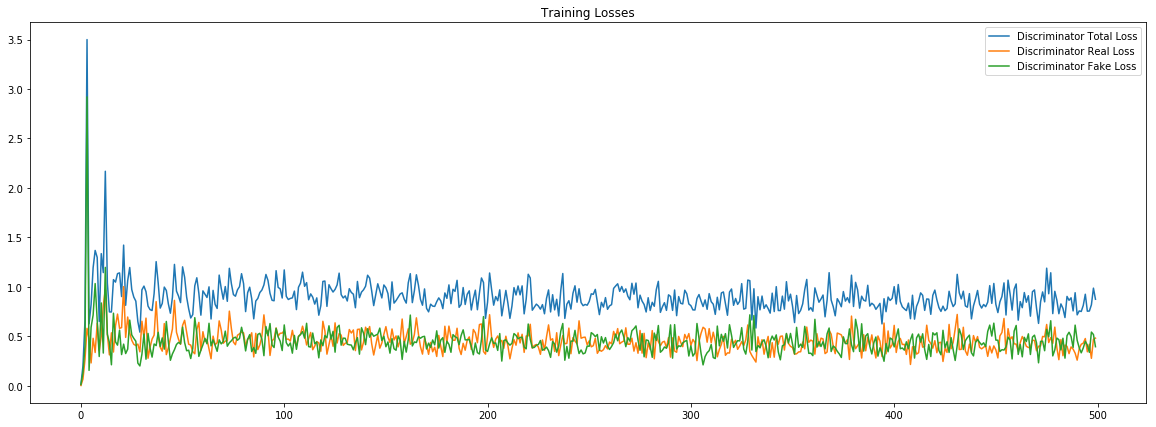

In [39]:
fig, ax = plt.subplots(figsize=(20,7))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator Total Loss')
plt.plot(losses.T[1], label='Discriminator Real Loss')
plt.plot(losses.T[2], label='Discriminator Fake Loss')
plt.title("Training Losses")
plt.legend()
plt.savefig('4.eps',format='eps')

In [28]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pickle.load(f)

In [29]:
def view_samples(epoch, samples):
    """
    epoch代表第几次迭代的图像
    samples为我们的采样结果
    """
    fig, axes = plt.subplots(figsize=(7,7), nrows=5, ncols=5, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch][1]): # 这里samples[epoch][1]代表生成的图像结果，而[0]代表对应的logits
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

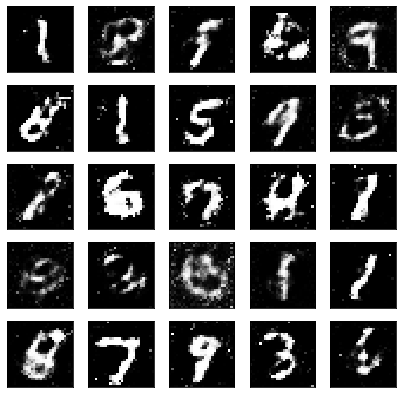

In [18]:
_ = view_samples(-1, samples) # 显示最后一轮的outputs

In [31]:
# 指定要查看的轮次
epoch_idx = [0, 5, 10, 20, 40, 60, 80, 100, 200, 300, 400, 499] # 一共300轮，不要越界
show_imgs = []
for i in epoch_idx:
    show_imgs.append(samples[i][1])

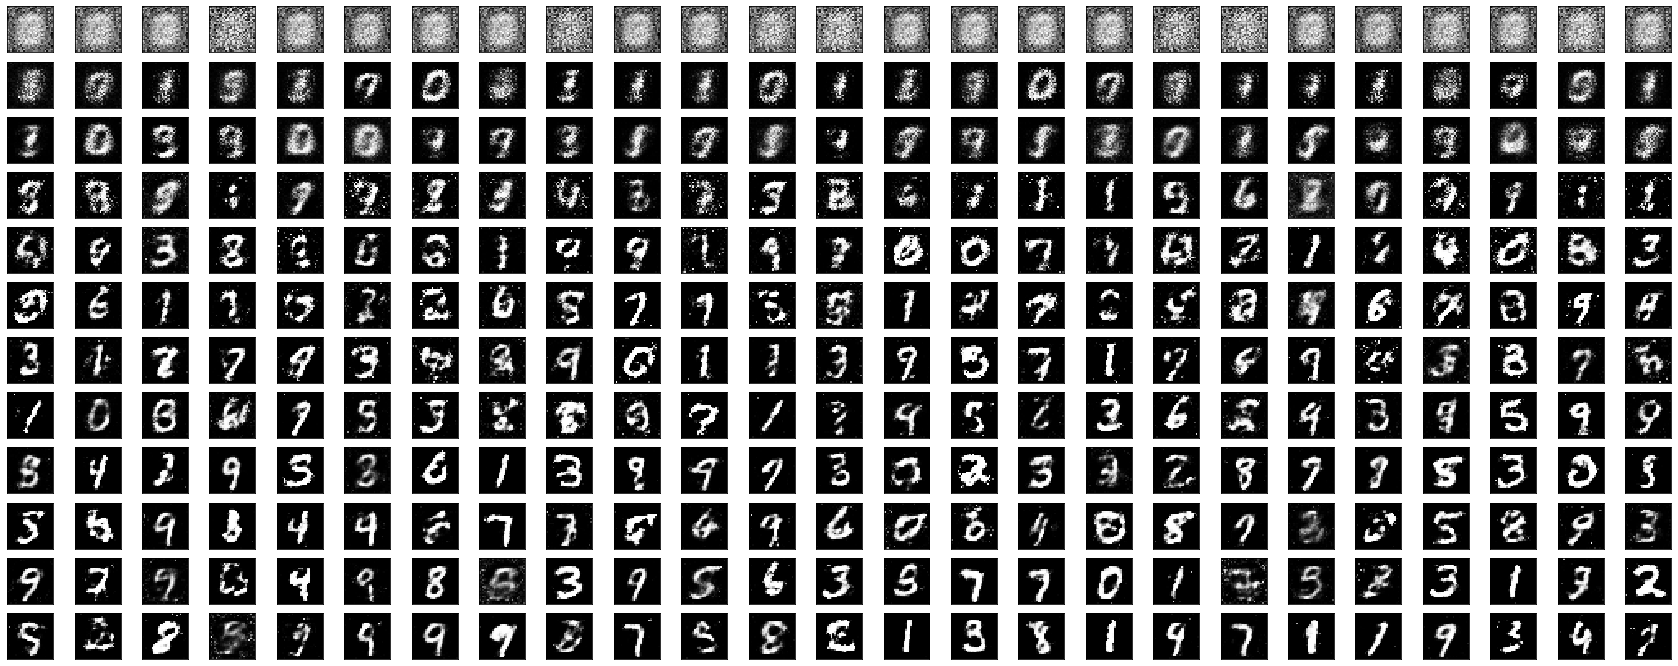

In [33]:
# 指定图片形状
rows, cols = 12, 25
fig, axes = plt.subplots(figsize=(30,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

idx = range(0, epochs, int(epochs/rows))

for sample, ax_row in zip(show_imgs, axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

In [34]:
# 加载我们的生成器变量
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_noise = np.random.uniform(-1, 1, size=(25, noise_size))
    gen_samples = sess.run(get_generator(noise_img, g_units, img_size, reuse=True),
                           feed_dict={noise_img: sample_noise})


INFO:tensorflow:Restoring parameters from checkpoints\generator.ckpt


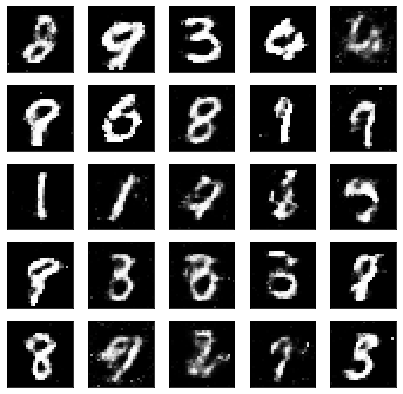

In [35]:
_ = view_samples(0, [gen_samples])